In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})

{'width': 1920, 'height': 1080, 'scroll': True}

<center><h1>EDA for Citation Network</h1></center>

<center><h1><span style="font-family:Papyrus;">План</span></h1></center>

<ul>
    <li><h2><span style="font-family:Papyrus;">Структура датасета</span></h2></li>
    <li><h2><span style="font-family:Papyrus;">Примеры данных</span></h2></li>
    <li><h2><span style="font-family:Papyrus;">Визуализация статистик</span></h2>
        <ul>
    <li><h3><span style="font-family:Papyrus;">Статьи</span></h3></li>
    <li><h3><span style="font-family:Papyrus;">Авторы</span></h3></li>
    <li><h3><span style="font-family:Papyrus;">Места публикации</span></h3></li>
    <li><h3><span style="font-family:Papyrus;">Числовые характеристики</span></h3>
            <ul>
        <li><h4><span style="font-family:Papyrus;">Год публикации</span></h4></li>
        <li><h4><span style="font-family:Papyrus;">Число цитирований</span></h4></li>
            </ul></li>
    <li><h3><span style="font-family:Papyrus;">Анализ текста</span></h3></li>
        </ul></li>
    <li><h2><span style="font-family:Papyrus;">Заключение</span></h2></li>
</ul>

In [2]:
from visualization import draw_word_cloud, draw_hbar
from data_processing import prerpocess_json

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings('ignore')

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

In [3]:
JSON_PATH = '/mnt/c/MADE_data/dblpv13.json'  # INPUT YOUR JSON PATH HERE IF YOUR JSON HAS NUMBERINT
FIXED_JSON_PATH = 'dblpv13_fixed.json'  # INPUT NAME OF THE PROCESSED JSON

# The next line may take quite a while.
# preprocess_json(JSON_PATH, FIXED_JSON_PATH) <-- uncomment if you don't have fixed json

In [4]:
spark = SparkSession \
        .builder \
        .master('local[*]') \
        .appName("PySpark for dblpv13") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
        .config("spark.driver.maxResultSize", "3g") \
        .getOrCreate()

22/10/05 02:29:48 WARN Utils: Your hostname, PK resolves to a loopback address: 127.0.1.1; using 172.23.13.131 instead (on interface eth0)
22/10/05 02:29:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/05 02:29:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
df = spark.read.json(FIXED_JSON_PATH)

<center><h1><span style="font-family:Papyrus;">Структура датасета</span></h1></center>

Весь датасет находится в `json`-файле размером в ~17 gb. Так как обработать его целиком может быть несколько затруднительно, было решено рассчитывать статистики и EDA на его подмножестве (4%).

Данные в датасете можно условно разделить на 3 группы:

- Статьи - различные данные по данной статье
- Авторы - список с данными об авторах статьи
- Места публикации - информация о месте публикации статьи
    
Посмотрим, из чего состоит каждая группа:

In [6]:
df.drop('authors', 'venue').printSchema()

root
 |-- _id: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- fos: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- isbn: string (nullable = true)
 |-- issn: string (nullable = true)
 |-- issue: string (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lang: string (nullable = true)
 |-- n_citation: double (nullable = true)
 |-- page_end: string (nullable = true)
 |-- page_start: string (nullable = true)
 |-- pdf: string (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- url: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- volume: string (nullable = true)
 |-- year: double (nullable = true)



In [7]:
df.select('authors').printSchema()

root
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- _id: string (nullable = true)
 |    |    |-- avatar: string (nullable = true)
 |    |    |-- bio: string (nullable = true)
 |    |    |-- email: string (nullable = true)
 |    |    |-- gid: string (nullable = true)
 |    |    |-- homepage: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- name_zh: string (nullable = true)
 |    |    |-- oid: string (nullable = true)
 |    |    |-- oid_zh: string (nullable = true)
 |    |    |-- orcid: string (nullable = true)
 |    |    |-- org: string (nullable = true)
 |    |    |-- org_zh: string (nullable = true)
 |    |    |-- orgid: string (nullable = true)
 |    |    |-- orgs: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- orgs_zh: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- position: string (nullable = t

In [8]:
df.select('venue').printSchema()

root
 |-- venue: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- issn: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- name_d: string (nullable = true)
 |    |-- name_s: string (nullable = true)
 |    |-- online_issn: string (nullable = true)
 |    |-- publisher: string (nullable = true)
 |    |-- raw: string (nullable = true)
 |    |-- raw_zh: string (nullable = true)
 |    |-- sid: string (nullable = true)
 |    |-- src: string (nullable = true)
 |    |-- t: string (nullable = true)
 |    |-- type: long (nullable = true)



In [9]:
# unique_df = df.select('lang').distinct().collect()
# pd.DataFrame(unique_df, columns=['lang'])

## Selecting subset and processing it

In [10]:
df_subset = df.sample(withReplacement=False, fraction=0.04, seed=117)

In [11]:
pd_df = df_subset.select([col for col in df_subset.columns if col not in ['authors', 'venue']]).toPandas()

In [11]:
pd_df.columns

Index(['_id', 'abstract', 'doi', 'fos', 'isbn', 'issn', 'issue', 'keywords',
       'lang', 'n_citation', 'page_end', 'page_start', 'pdf', 'references',
       'title', 'url', 'volume', 'year'],
      dtype='object')

In [12]:
authors_cols = [ 
    '_id',
    'avatar',
    'bio',
    'email',
    'gid',
    'homepage',
    'name',
    'name_zh',
    'oid',
    'oid_zh',
    'orcid',
    'org',
    'org_zh',
    'orgid',
    'orgs',
    'orgs_zh',
    'position',
    'sid'
]
pd_authors_df = df_subset.select(['authors.' + col for col in authors_cols]).toPandas()

In [13]:
venue_cols = [
    '_id',
    'issn',
    'name',
    'name_d',
    'name_s',
    'online_issn',
    'publisher',
    'raw',
    'raw_zh',
    'sid',
    'src',
    't'
]
pd_venue_df = df_subset.select(['venue.' + col for col in venue_cols]).toPandas()

<center><h1><span style="font-family:Papyrus;">Примеры данных</span></h1></center>

In [14]:
pd_df.head()

,_id,abstract,doi,fos,isbn,issn,issue,keywords,lang,n_citation,page_end,page_start,pdf,references,title,url,volume,year
0,53e99784b7602d9701f3eaf4,,10.1145/1186015.1186050,None,1-58113-896-2,,,[],en,0.0,197,197,None,None,1may,"[http://dx.doi.org/10.1145/1186015.1186050, ht...",,2004.0
1,53e99784b7602d9701f3f8d2,None,10.1016/j.currproblcancer.2015.04.001,None,,1535-6345,2,[],en,18.0,69,69,None,None,Foreword.,[http://dx.doi.org/10.1016/j.currproblcancer.2...,39,1962.0
2,53e99784b7602d9701f3f966,,10.1524/itit.2000.42.4.5,None,None,None,4,[],en,1.0,6,5,None,None,Feldbustechnik,[http://dx.doi.org/10.1524/itit.2000.42.4.5],42,2000.0
3,53e99784b7602d9701f3f980,None,None,None,None,None,None,[],en,0.0,None,None,None,None,Fovea.,None,None,2009.0
4,53e99784b7602d9701f3f622,"In todayʼs economically volatile climate, any ...",10.1016/S0074-7696(08)62596-6,None,0-7484-0127-X,0044-0086,3-4,"[International Symposium, Demographic Paramete...",en,1.0,162,161.b1,//static.aminer.org/pdf/PDF/001/228/637/forewo...,None,Foreword.,[http://dx.doi.org/10.1016/S0074-7696(08)62596...,34,1961.0


In [15]:
pd_authors_df[120:125]

,_id,avatar,bio,email,gid,homepage,name,name_zh,oid,oid_zh,orcid,org,org_zh,orgid,orgs,orgs_zh,position,sid
120,[53f45d5fdabfaee02ad72253],[None],[None],[None],[None],[None],[Shunsaku hayashi],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None]
121,"[56017a7445cedb3395e5fcdb, 53f63b0edabfaea3ccc...","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[Clyde W. Holsapple, Andrew B. Whinston]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]"
122,"[53f47579dabfaedf43680f5f, 53f44829dabfaee2a1d...","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[Robert Delano, Brian Parise, Leanne West]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]"
123,[53f460bbdabfaeee22a3efe2],[None],[None],[None],[None],[None],[Hermann K.-G. Walter],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None]
124,"[53f7e17adabfae938c6e6b12, 5405a437dabfae450f3...","[None, None, None, None]","[None, None, None, None]","[None, None, None, None]","[5b86b6c4e1cd8e14a34cb8e8, 5b86b6bfe1cd8e14a34...","[None, None, None, None]","[Andrea Corradini, Hartmut Ehrig, Grzegorz Roz...","[None, None, None, None]","[None, None, None, None]","[None, None, None, None]","[None, None, None, None]","[Pisa, Berlin, Leiden, Berlin]","[None, None, None, None]","[5f71b2dc1c455f439fe3ecb0, None, None, None]","[None, None, None, None]","[None, None, None, None]","[None, None, None, None]","[None, None, None, None]"


In [16]:
pd_venue_df.head()

,_id,issn,name,name_d,name_s,online_issn,publisher,raw,raw_zh,sid,src,t
0,5736ae3ad39c4f40a7976010,None,None,None,None,None,None,SIGGRAPH Computer Animation Festival,None,None,None,None
1,53a7314420f7420be8d31c79,None,None,None,None,None,None,IEICE Transactions,None,None,None,None
2,53a731f120f7420be8d6d308,None,None,None,None,None,None,it+ti - Informationstechnik und Technische Inf...,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None
4,593a046d9ed5db23ccac07af,None,None,None,None,None,None,IEEE Trans. Knowl. Data Eng.,None,None,None,None


<center><h1><span style="font-family:Papyrus;">Визуализации статистик</span></h1></center>

Для анализа датасета и его обработки были собраны следующие данные:

- Процентное соотношение "мусорных" значений
- Максимальная длина строки в поле (для строковых типов)
- Количество уникальных значений полей

В самом ноутбуке можно также посмотреть на примеры уникальных значений.

<center><h2><span style="font-family:Papyrus;">Статьи</span></h2></center>

In [17]:
nans_fraction = {}
max_lens = {}
unique = {}

for col in pd_df:
    if col in ['_id', 'abstract', 'doi', 'isbn', 'issue', 'issn', 'page_end', 'page_start', 'pdf', 'title', 'volume', 'lang']:
        nans = sum((pd_df[col].isna()) | (pd_df[col] == ''))
        nans_fraction[col] = nans / len(pd_df[col]) * 100
        if col not in ['abstract']:
            max_lens[col] = pd_df[col].str.len().max()
    if col in ['fos', 'keywords', 'references', 'url']:
        nans_fraction[col] = 0
        for value in pd_df[col]:
            if value is None or all(elem is None or elem == '' for elem in value):
                nans_fraction[col] += 1
        nans_fraction[col] = nans_fraction[col] / len(pd_df[col]) * 100
        
        for elem in pd_df[col]:
            if elem is not None:
                cur_max = max(elem, default='', key=len)
                if cur_max is not None and cur_max != '':
                    max_lens[col] = max(max_lens.get(col, 0), len(cur_max))
        
    if col not in ['_id', 'references', 'url', 'keywords']:
        unique[col] = pd_df[col].explode().unique()

unique_num = {label: len(value) for label, value in unique.items()}

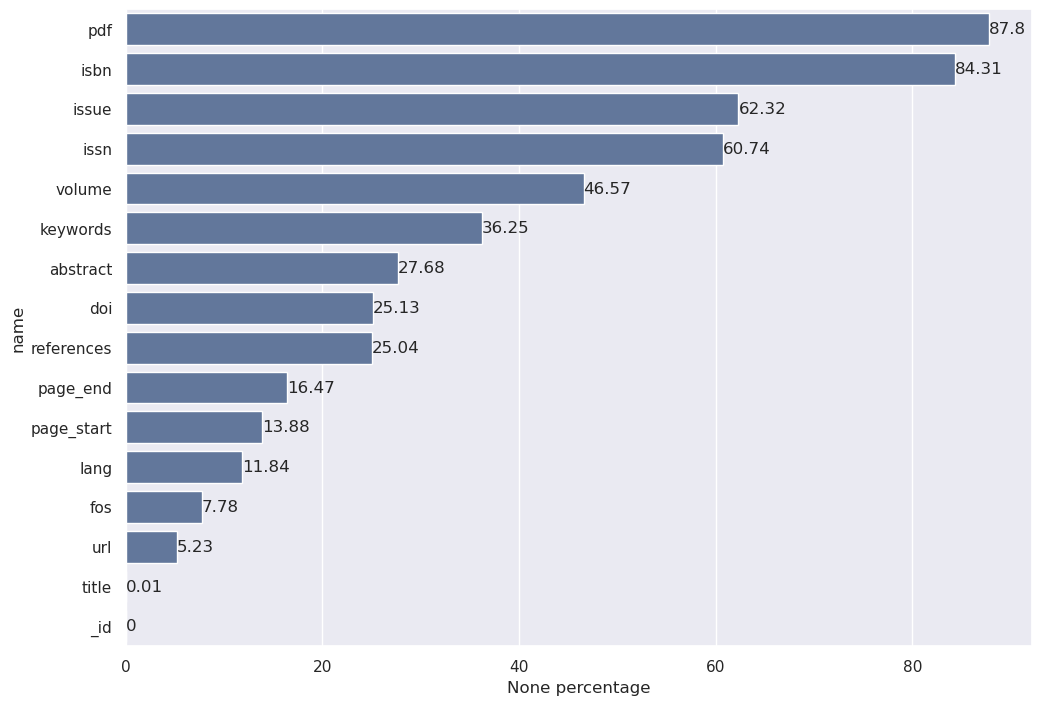

In [18]:
draw_hbar(nans_fraction, x_name='None percentage')

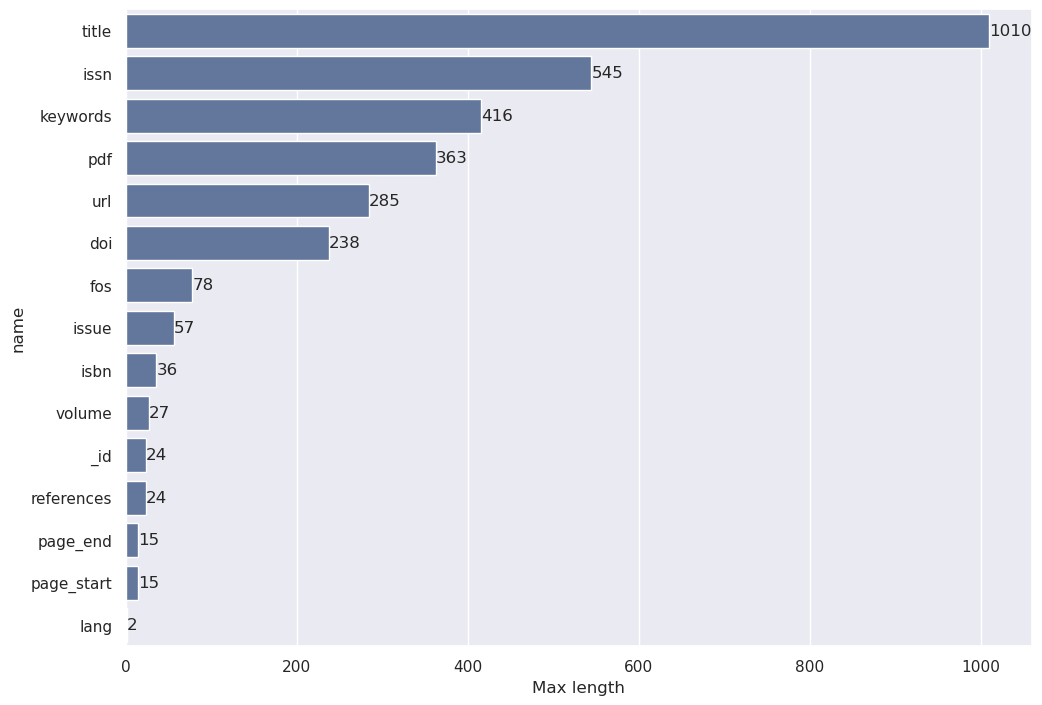

In [19]:
draw_hbar(max_lens, x_name='Max length')

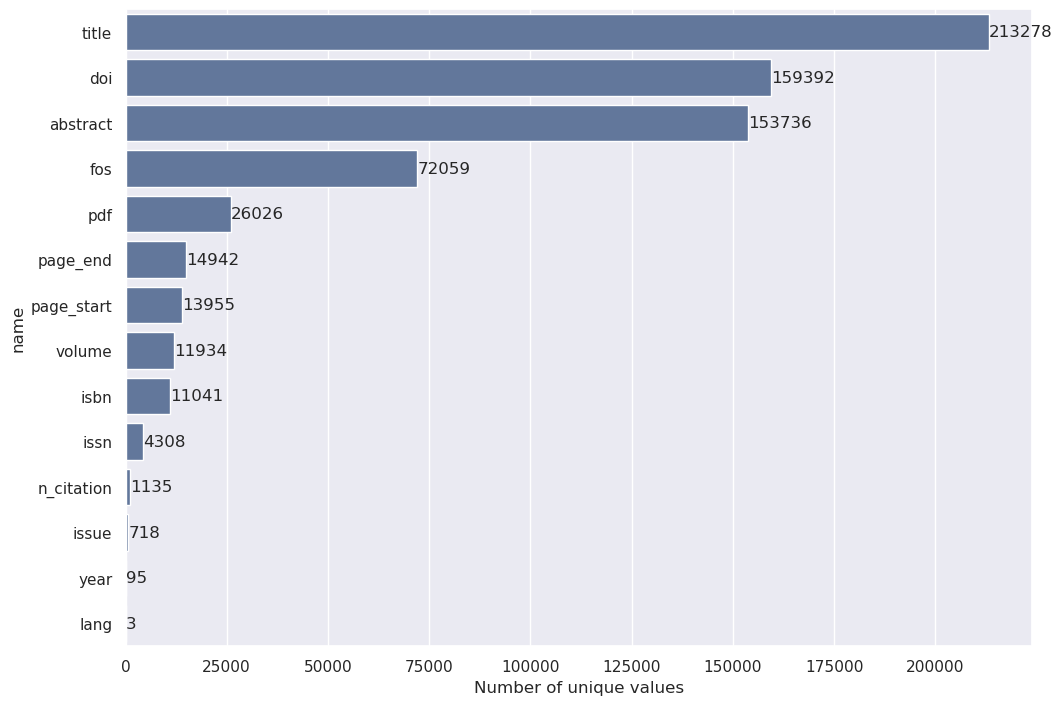

In [20]:
draw_hbar(unique_num, x_name='Number of unique values')

<center><h2><span style="font-family:Papyrus;">Авторы</span></h2></center>

In [21]:
nans_fraction = {}
max_lens = {}
unique = {}        

for col in pd_authors_df:
    max_lens['authors.' + col] = 0
    for elem in pd_authors_df[col]:
        if elem is not None:
            cur_max = max(elem, default='', key=lambda x: -1 if x is None else len(x))
            if cur_max is not None and cur_max != '':
                max_lens['authors.' + col] = max(max_lens.get('authors.' + col, 0), len(cur_max))
                if col not in ['bio', '_id', 'name']:
                    unique['authors.' + col] = unique.get('authors.' + col, [])
                    unique['authors.' + col].append(cur_max)
            else:
                nans_fraction['authors.' + col] = nans_fraction.get('authors.' + col, 0) + 1
    nans_fraction['authors.' + col] = nans_fraction.get('authors.' + col, 0) / len(pd_authors_df[col]) * 100

unique_num = {label: len(value) for label, value in unique.items()}

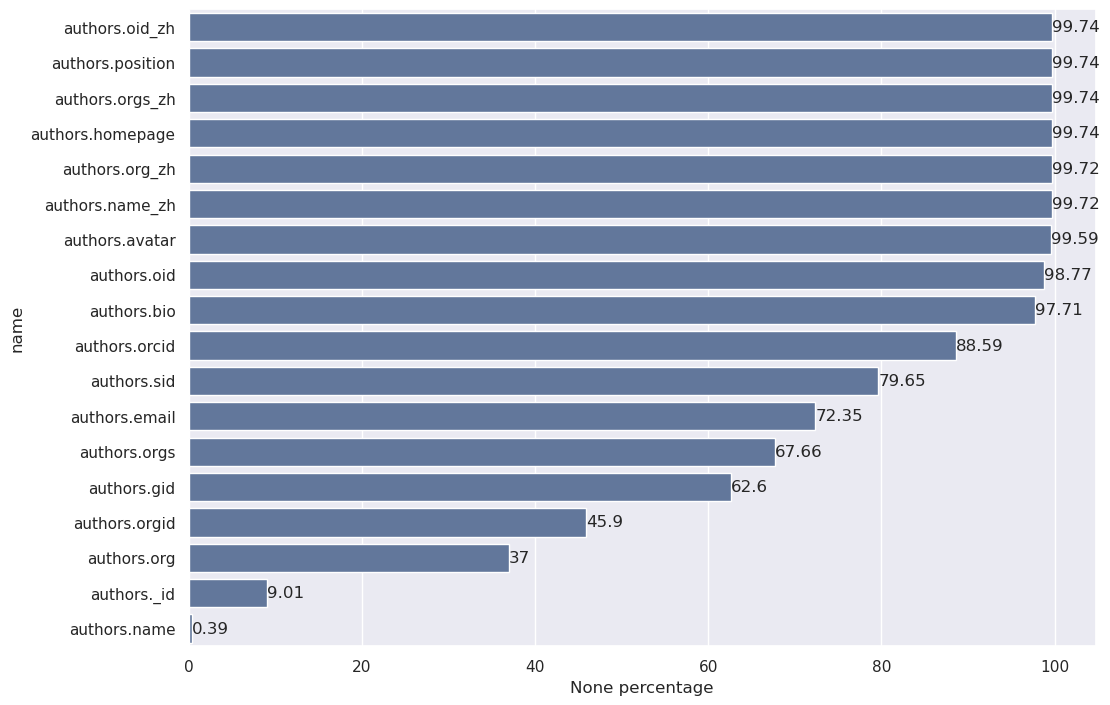

In [22]:
draw_hbar(nans_fraction, x_name='None percentage')

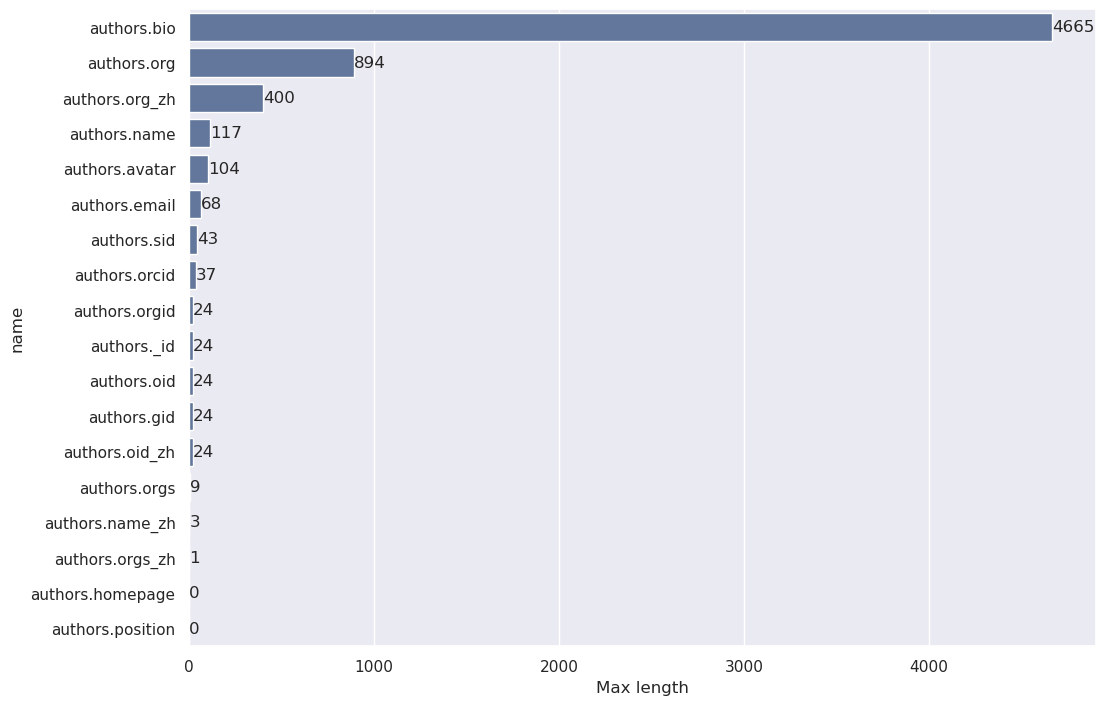

In [23]:
draw_hbar(max_lens, x_name='Max length')

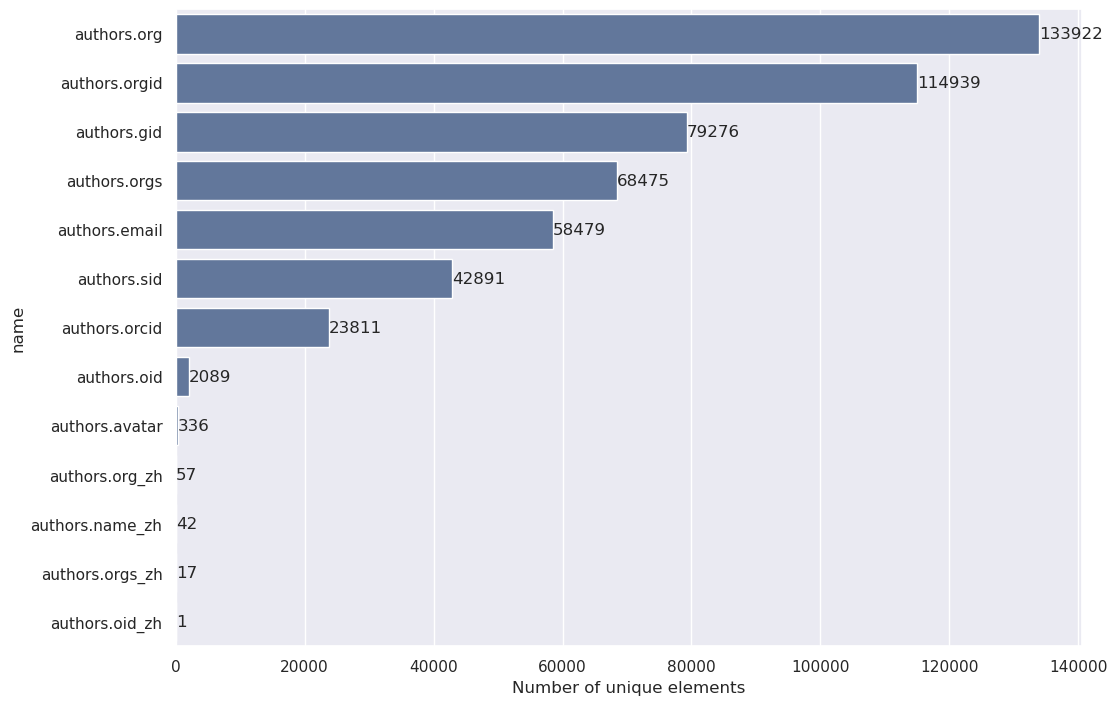

In [24]:
draw_hbar(unique_num, x_name='Number of unique elements')

<center><h2><span style="font-family:Papyrus;">Места публикации</span></h2></center>

In [25]:
nans_fraction = {}
max_lens = {}
unique = {}
        
for col in pd_venue_df:
    if col != 't':
        max_str = max(pd_venue_df[col].astype('unicode'), key=len)
        max_lens['venue.' + col] = pd_venue_df[col].str.len().max()
    nans = sum(pd_venue_df[col].isna())
    nans_fraction['venue.' + col] = nans / len(pd_venue_df[col]) * 100
    unique['venue.' + col] = pd_venue_df[col].apply(str).unique()

unique_num = {label: len(value) for label, value in unique.items()}

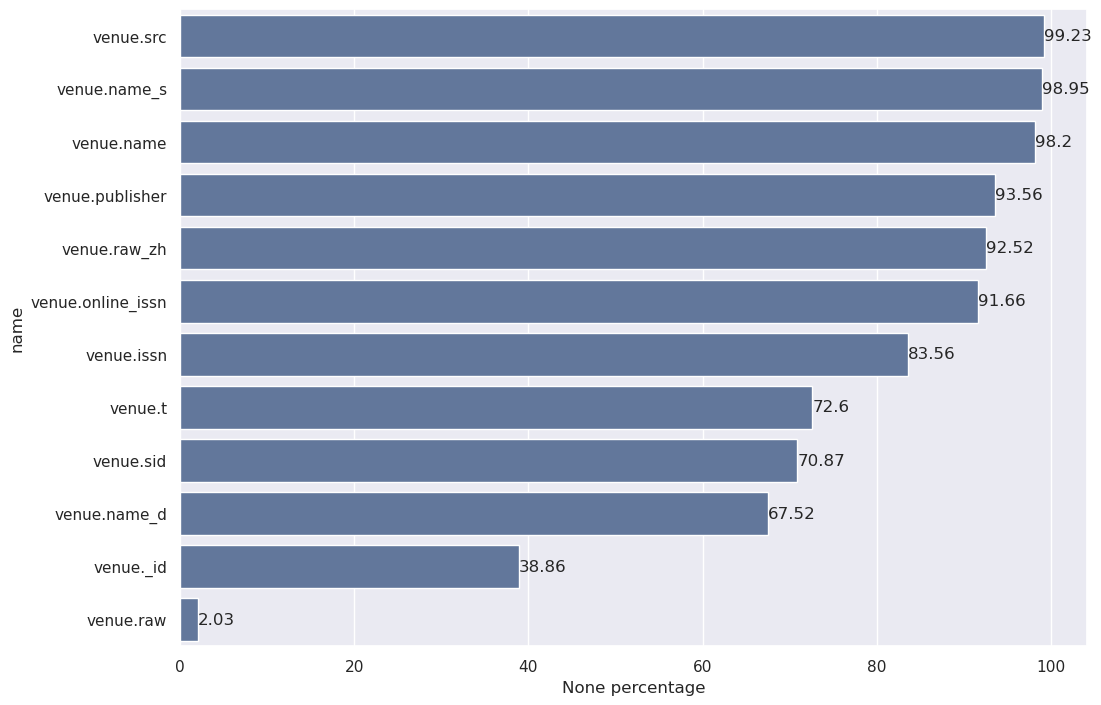

In [26]:
draw_hbar(nans_fraction, x_name='None percentage')

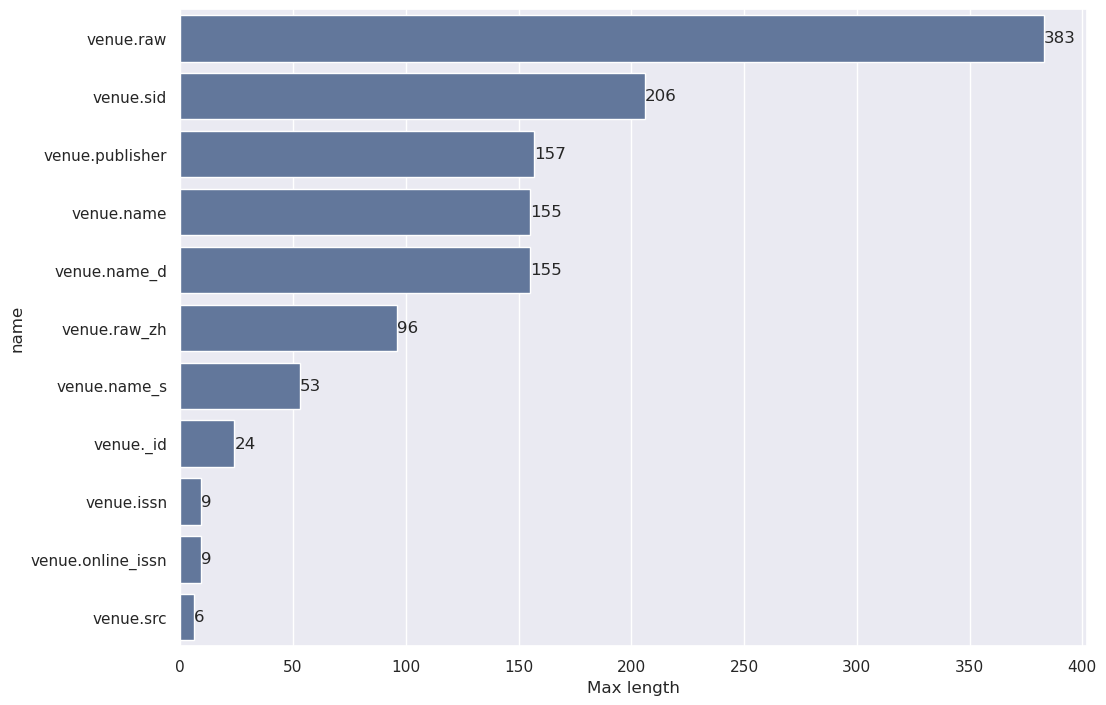

In [27]:
draw_hbar(max_lens, x_name='Max length')

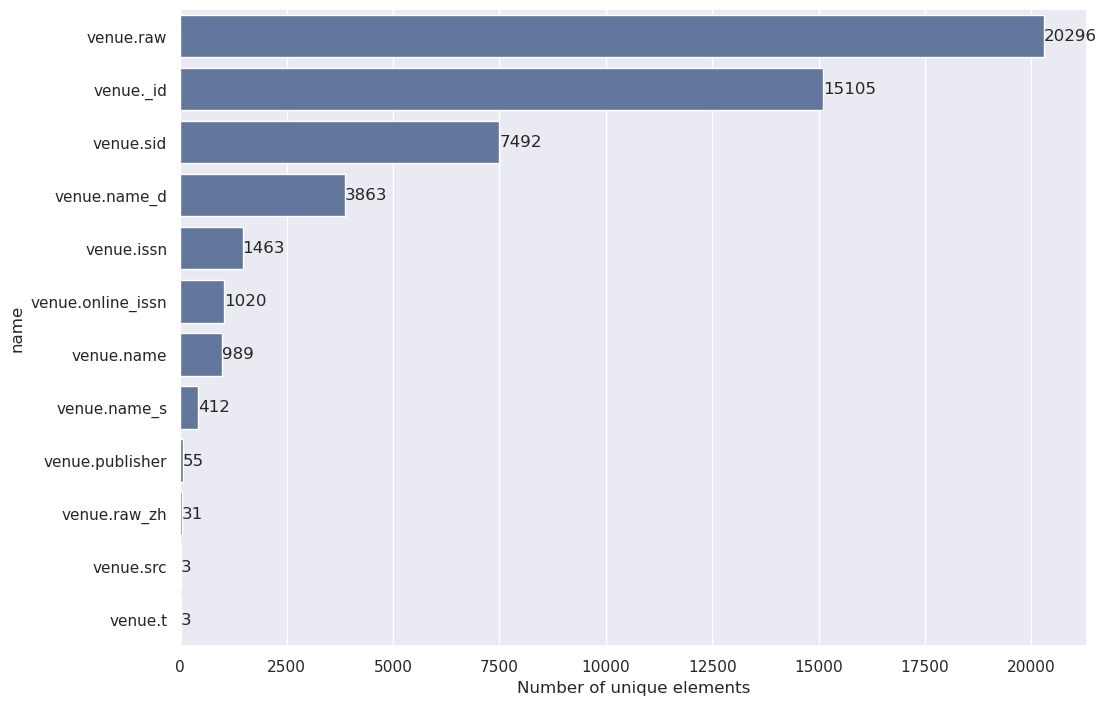

In [28]:
draw_hbar(unique_num, x_name='Number of unique elements')

<center><h2><span style="font-family:Papyrus;">Числовые признаки</span></h2></center>

Были выделены следующие числовые признаки:

- Год публикации
- Число цитирований

Для каждого признака первично построен `boxplot` для оценки разброса значений, после чего убраны выбросы и скорректированы пределы для визуализации гистограмм.

<center><h2><span style="font-family:Papyrus;">Год публикации</span></h2></center>

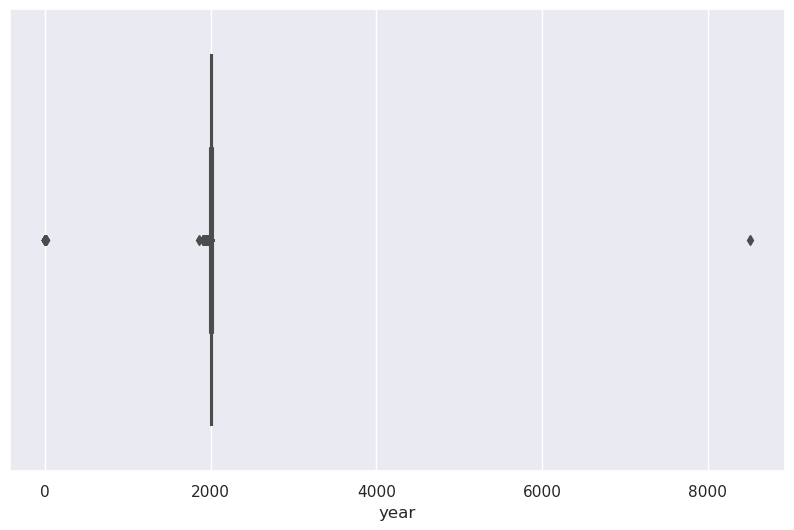

In [12]:
sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(data=pd_df, x='year', orient='x', showfliers=True)
plt.show()

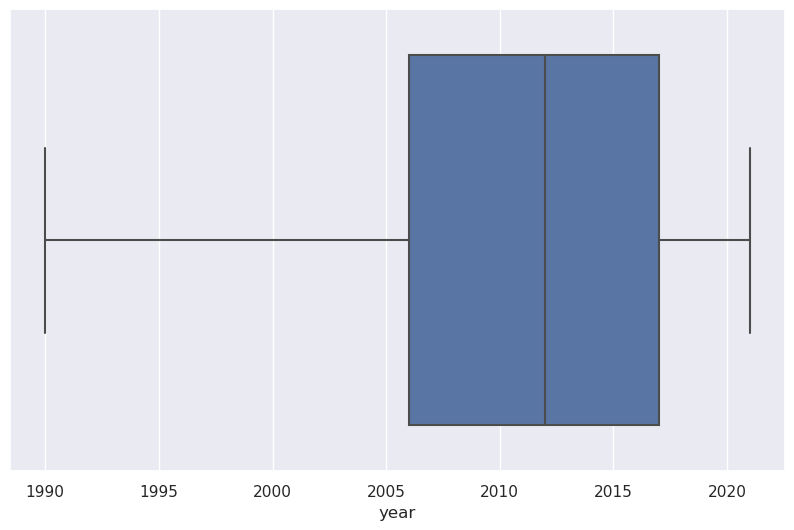

In [14]:
sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(data=pd_df, x='year', orient='x', showfliers=False)
plt.show()

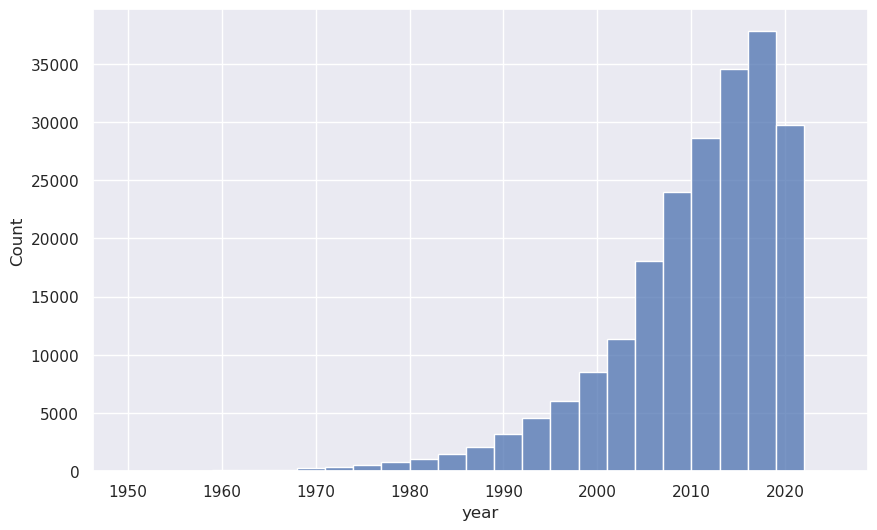

In [15]:
sns.set(rc={'figure.figsize':(10,6)})
sns.histplot(data=pd_df, x='year', binrange=(1950, 2023), binwidth=3, fill=True)
plt.show()

<center><h2><span style="font-family:Papyrus;">Число цитирований</span></h2></center>

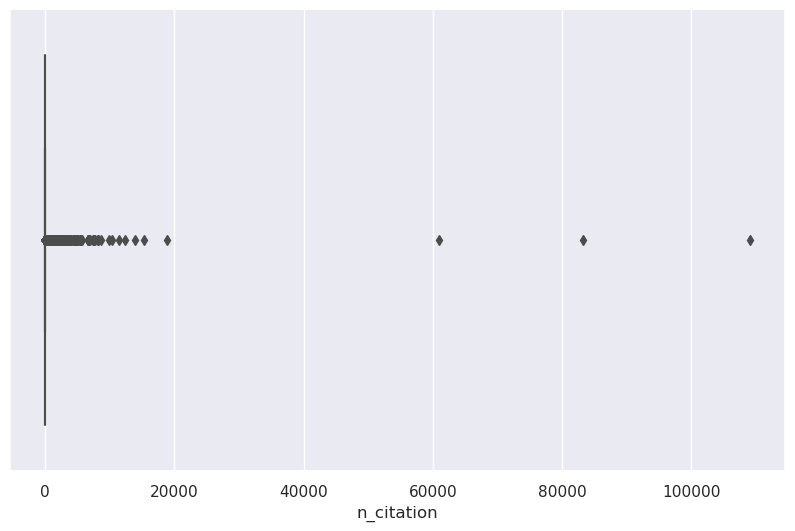

In [16]:
sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(data=pd_df, x='n_citation', orient='x', showfliers=True)
plt.show()

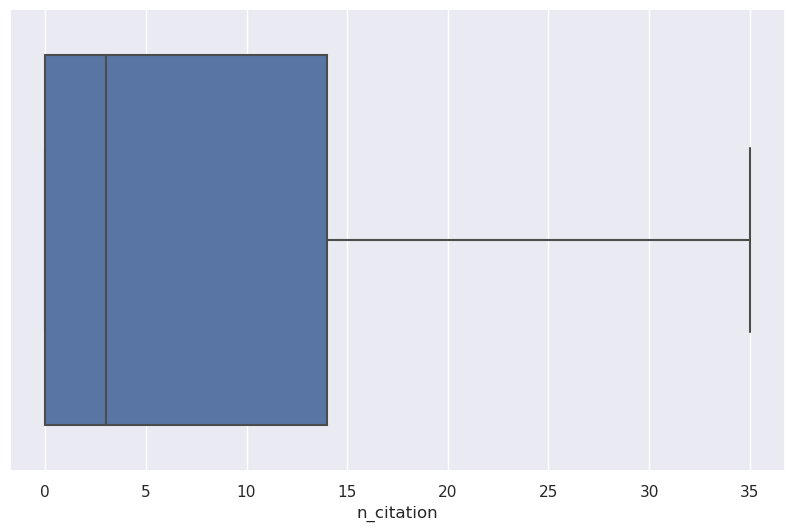

In [17]:
sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(data=pd_df, x='n_citation', orient='x', showfliers=False)
plt.show()

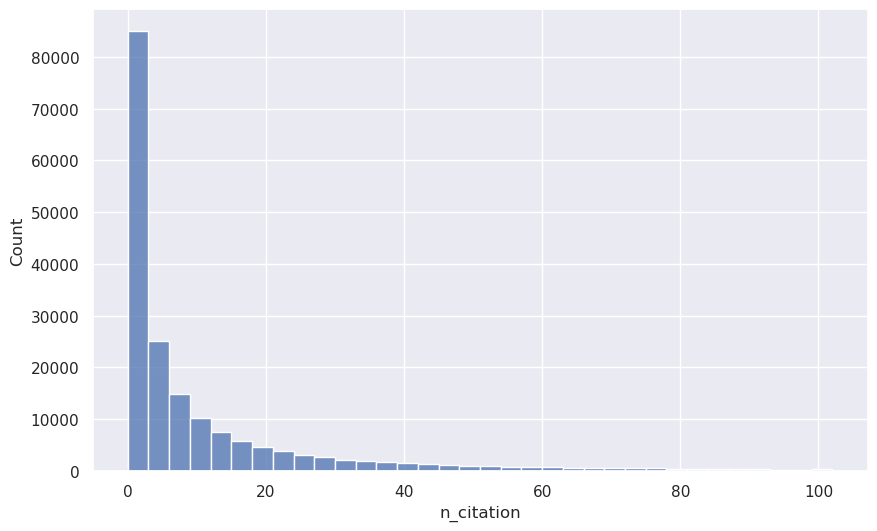

In [18]:
sns.set(rc={'figure.figsize':(10,6)})
sns.histplot(data=pd_df, x='n_citation', binrange=(0, 100), binwidth=3)
plt.show()

<center><h2><span style="font-family:Papyrus;">Анализируем текст</span></h2></center>

Для визуального анализа текста использовался `Bag of Words (BoW)`. 

Для каждого слова в корпусе были построены `TF-IDF`-вектора для униграмм и биграмм, которые далее использовались для отрисовки в `Word Cloud`. 

Слова в тексте предварительно лемматизированы (`WordNetLemmatizer`), знаки препинания убраны, а стоп-слова (к `stopwords` из `nltk` добавлены неиформативные слова, которые обнаруживались во время экспериментов) убраны.

In [19]:
# Not needed if you already have loaded dataset. Set abstracts = pd_df['abstract'] if that's the case.
subs_df = spark.read.parquet('subset_data.parquet')  
abstracts = subs_df.select('abstract').toPandas()
abstracts = abstracts['abstract']

# Clear obvious junk values
abstracts = abstracts[abstracts.notna() & (abstracts != '')]

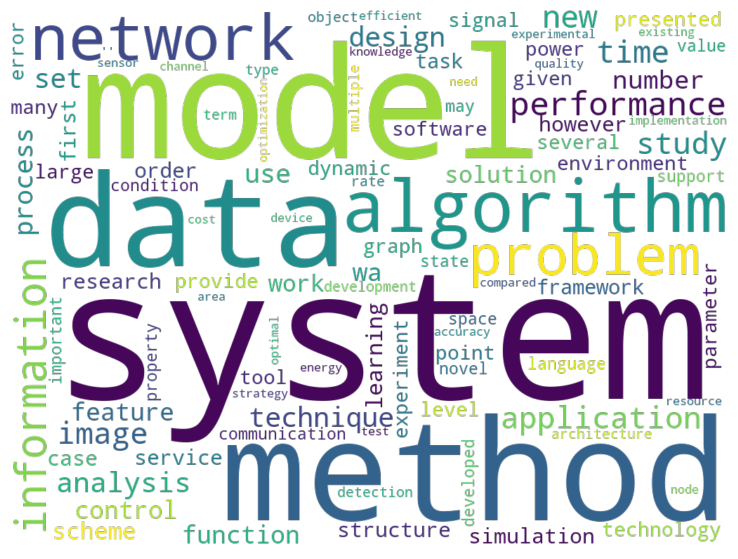

In [36]:
draw_word_cloud(abstracts)

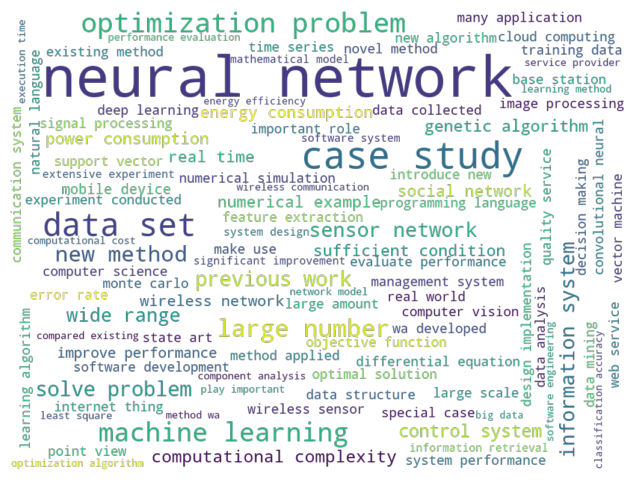

In [20]:
draw_word_cloud(abstracts, ngram_range=(2, 2), max_words=500)

In [ ]:
# If kernel dies at this point - consider changing memory params in Spark 
# and/or running directly from the place of reading the parquet file.

<center><h1><span style="font-family:Papyrus;">Заключение</span></h1></center>

Из анализа датасета были сделаны следующие выводы:
- Некоторые поля имеет смысл удалить:
    - содержащие слишком много `None`-значений, так что надеяться на них при инференсе не стоит;
    - слишком зашумленные поля, их точный учёт в модели не принесёт много пользы (`orgs`);
    - занимающие много места поля, которые сложно использовать (`authors.bio`);
    - дублирующиеся поля, причём не всегда присутствующие копии (`issn`-`venue.issn`).
- Некоторые поля имеет смысл заменить:
    - `orgs` на `orgs_count`;
    - `page_begin`, `page_end` на `article_length`.
- Поля, которые останутся, требуется обрабатывать, например:
    - В поле `year` говорится о статьях, которые будут написаны через несколько тысячелетий;
    - Поля `keywords` и `fos` содержат очень ценные данные с точки зрения задачи `Topic modelling` и рекомендательных систем;
    - Некоторые поля содержат "интересные" пустые значения (строки `"null"`, пустые строки, `None`-значения), особенно списки.

Будем использовать следующие поля:
- old_id
- title
- abstract
- has_doi
- issn
- isbn
- article_len
- n_citation
- lang
- year
- keywords
- references
- fos
- authors:
    - email
    - gid
    - nameorg
    - orgid
    - sid
    - old_id
    - orgs_count
- venue:
    - old_id
    - name_d
    - raw
    - sid
    - type